# Demo of work with microscopy data with DataJoint
The project is hosted at https://github.com/ActiveBrainAtlas/Orofacial_Collaboration

The project uses cloud store using a relational datababase and S3 for bulk storage.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import numpy as np

import tempfile
import datajoint as dj
from minio import Minio
from os import path
import json
import re

`glymur` is the Python API for OpenJPEG. The installation instructions are at https://glymur.readthedocs.io/en/latest/detailed_installation.html

It requires installing openjpeg.

If you use `brew` on MacOS, then the installation can be done as:
```shell
$ brew install openjpeg
$ pip install glymur
```

In [2]:
import glymur

In [4]:
schema = dj.schema('common_distributed')   # please replace it with your database 

Connecting dimitri@ucsd-demo-db.datajoint.io:3306


In [5]:
def get_s3_client():
    with open('s3-creds.json') as f:
        creds = json.load(f)
    return Minio('s3.amazonaws.com', secure=True, **creds)

In [6]:
@schema
class BaseImage(dj.Manual):
    definition = '''
    image_id:          int            # image id
    ---
    image_location:    varchar(1024)  # image location in bucket
    filesize : bigint  # (bytes)
    '''
    
    bucket_name = 'mousebraindata-open'
    
    @classmethod
    def fill(cls):   
        """
        fill the image list from the bucket
        """
        client = get_s3_client()
        objects = client.list_objects(BaseImage.bucket_name, prefix='MD657/')
        cls.insert(
            dict(image_id=i, image_location=obj.object_name, filesize=obj.size) 
            for i, obj in enumerate(objects) if obj.object_name.endswith('.jp2'))

In [7]:
if not BaseImage(): 
    # load directory from the repository
    BaseImage.fill()

In [8]:
@schema
class BaseProperties(dj.Computed):
    definition = """
    # Image properties inferred from file name
    -> BaseImage
    ---
    prep : varchar(16)
    image_datetime : datetime
    letter_number : char(8)
    major : smallint
    minor : smallint
    lossy : bool
    """
    def make(self, key):
        path = (BaseImage & key).fetch1('image_location')
        match = re.match(
            r'(?P<prep>\w*)/(?P=prep)-(?P<letter_number>\w*)-'
            r'(?P<date>\d{4}\.\d\d\.\d\d)-(?P<time>\d\d\.\d\d\.\d\d)_(?P=prep)_'
            r'(?P<major>\d+)_(?P<minor>\d+)_(?P<lossy>(lossy|lossless))\.jp2', path).groupdict()
        match['image_datetime'] = str.replace(match['date'], '.', '-') + ' ' + str.replace(match['time'], '.', ':')
        match['lossy'] = match['lossy'] == 'lossy' 
        self.insert1(dict(key, **match),  ignore_extra_fields=True)

In [9]:
BaseProperties.populate(display_progress=True)

0it [00:00, ?it/s]


In [10]:
BaseProperties * BaseImage & {'lossy': True}

image_id image id,prep,image_datetime,letter_number,major,minor,lossy,image_location image location in bucket,filesize (bytes)
6,MD657,2017-02-17 17:39:26,F1,1,1,1,MD657/MD657-F1-2017.02.17-17.39.26_MD657_1_0001_lossy.jp2,14478371
12,MD657,2017-02-17 17:39:26,F1,2,2,1,MD657/MD657-F1-2017.02.17-17.39.26_MD657_2_0002_lossy.jp2,15245894
18,MD657,2017-02-17 17:39:26,F1,3,3,1,MD657/MD657-F1-2017.02.17-17.39.26_MD657_3_0003_lossy.jp2,15207827
24,MD657,2017-02-17 19:35:42,F10,1,28,1,MD657/MD657-F10-2017.02.17-19.35.42_MD657_1_0028_lossy.jp2,36016872
30,MD657,2017-02-17 19:35:42,F10,3,30,1,MD657/MD657-F10-2017.02.17-19.35.42_MD657_3_0030_lossy.jp2,36485376
36,MD657,2017-02-21 17:57:42,F10,1,28,1,MD657/MD657-F10-2017.02.21-17.57.42_MD657_1_0028_lossy.jp2,25894421
42,MD657,2017-02-21 17:57:42,F10,2,29,1,MD657/MD657-F10-2017.02.21-17.57.42_MD657_2_0029_lossy.jp2,28821054
48,MD657,2017-02-21 17:57:42,F10,3,30,1,MD657/MD657-F10-2017.02.21-17.57.42_MD657_3_0030_lossy.jp2,29215958
54,MD657,2017-02-17 19:39:47,F11,1,31,1,MD657/MD657-F11-2017.02.17-19.39.47_MD657_1_0031_lossy.jp2,29599098
60,MD657,2017-02-17 19:39:47,F11,2,32,1,MD657/MD657-F11-2017.02.17-19.39.47_MD657_2_0032_lossy.jp2,35493076


In [11]:
@schema
class Thumbnail(dj.Imported):
    definition = """
    # Downsampled images from BaseImage
    -> BaseProperties
    ---
    image_width :  int  # (Voxels) original image width 
    image_height :  int  # (voxels) original image height
    image_depth : int # (voxels) original image depth (e.g. 3 for RGB)
    downsample : smallint  
    thumbnail : longblob
    """
    
    def make(self, key):
        path = (BaseImage & key).fetch1('image_location')
        client = get_s3_client()
        data = client.get_object(BaseImage.bucket_name, path).data
        f = tempfile.NamedTemporaryFile(delete=False)
        f.write(data)
        f.close()
        img = glymur.Jp2k(f.name)
        d = 32
        self.insert1(dict(
            key, 
            **dict(zip(('image_height', 'image_width', 'image_depth'), img.shape)), 
            downsample=d, thumbnail=np.uint8(np.maximum(0, np.minimum(255, img[::d, ::d, :])))))

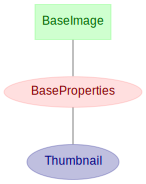

In [12]:
dj.ERD(schema)

In [13]:
Thumbnail.populate('lossy=1', display_progress=True, reserve_jobs=True, limit=3)

100%|██████████| 3/3 [00:56<00:00, 18.72s/it]


In [14]:
schema.jobs

table_name className of the table,key_hash key hash,"status if tuple is missing, the job is available",key structure containing the key,error_message error message returned if failed,error_stack error stack if failed,user database user,host system hostname,pid system process id,connection_id connection_id(),timestamp automatic timestamp


In [15]:
Thumbnail()

image_id image id,image_width (Voxels) original image width,image_height (voxels) original image height,image_depth (voxels) original image depth (e.g. 3 for RGB),downsample,thumbnail
6,11798,10617,3,32,=BLOB=
12,11304,10401,3,32,=BLOB=
18,11658,10401,3,32,=BLOB=
24,13560,13313,3,32,=BLOB=
30,13561,13312,3,32,=BLOB=
36,12982,10073,3,32,=BLOB=
42,15244,9642,3,32,=BLOB=
48,12701,9066,3,32,=BLOB=
54,14125,10298,3,32,=BLOB=
60,14409,11377,3,32,=BLOB=


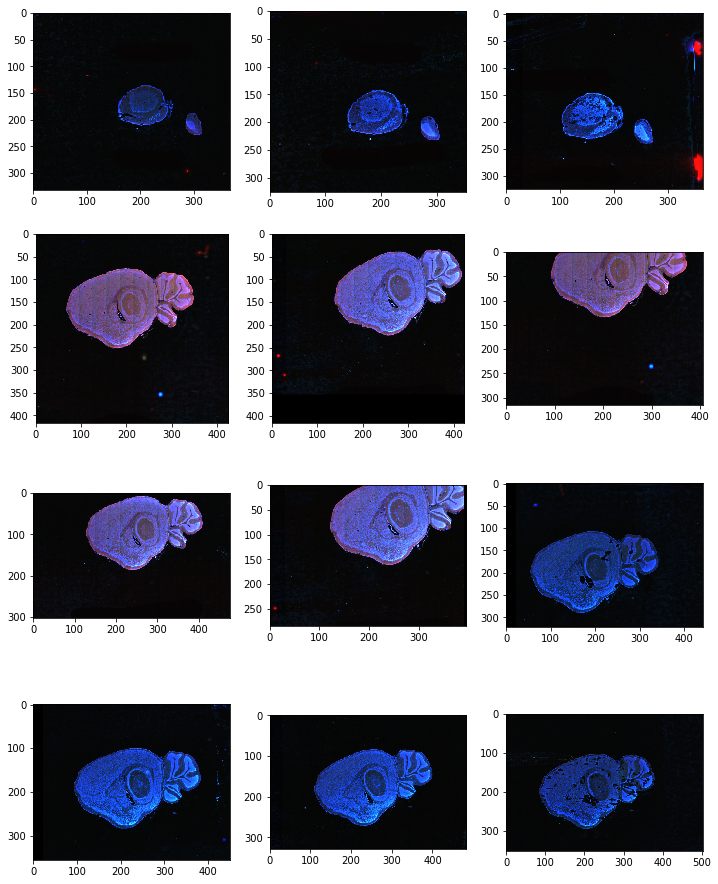

In [16]:
fig, ax = plt.subplots(4, 3, figsize=(12,16))
for a, thumb in zip(ax.flatten(), Thumbnail()):
    a.imshow(np.maximum(0, np.minimum(255, thumb['thumbnail'])))